# Sentiment analysis with Finnish AFINN models
#### - Hate Speech (HS) binary labels (0, 1) as 'no HS' and 'HS'
#### - For HS dataset of 'raw' and 'corrected' samples
#### - Parsing, preprocessing and AFINN based classification

### This script was published as a part of research work
This script was created and published by Merja Kreivi-Kauppinen.

This script is part of research work carried at University of Oulu in 2020-2023.

Topic of research work and thesis:
'Signs of Paradigm Shift in Hate Speech Detection Methodology: Hate Speech Detection of Dialectal, Granular and Urban Finnish'


### Method of sentiment analysis

HS binary classification with afinn SA was carried on lemmatized samples, where only original and lemma words were used to get sentiment scoring for text samples. Emoticons and emojis were not taken into account in sentiment scoring.

Text samples were lemmatized with experimental Finnish Voikko method designed for Spacy (Spacy version 3.5.0) using large Finnish language model 'fi_core_news_lg' the source of tokens.

Text samples were further tokenized with NLTK casual tokenization method, and set to lower capitals before feeding to afinn scoring process.

Samples which sum of scores were above zero got prediction label '1' indicated the 'HS' label, samples which got zero '0' as sentiment scoring value indicated 'not HS' label.

Scoring was carried for 'raw' text samples and manually 'corrected' text samples.

Results were analyzed with methods of scikit-learn library by calculating confusion matrix, and accuracy, F1, precision and recall scores for binary classifier.

### Original afinn available in GitHub
Original version of Afinn method available at GitHub: https://github.com/fnielsen/afinn 
 - Reference:
Finn Årup Nielsen, "A new ANEW: evaluation of a word list for sentiment analysis in microblogs", 
Proceedings of the ESWC2011 Workshop on 'Making Sense of Microposts': 
Big things come in small packages. Volume 718 in CEUR Workshop Proceedings: 93-98. 2011 May. 
Matthew Rowe, Milan Stankovic, Aba-Sah Dadzie, Mariann Hardey (editors)

### Finnish AFINN lexicon for binary classification of hate speech (HS)

Documentation of FINNfin library available as README.

Finnish AFINN for binary classification of hate speech (HS) uses lexicon which includes basic, pended, subword and lemma forms of words and their binary labels.

Each word is labeled with one sentiment label, where zero '0' presents 'no HS' label and one '1' presents 'HS' label.

Words were labeled as HS according to the list of 'Finnish hate speech search terms'. (Rauta 2018) 

Several different types of swearing, bullying, teasing, and insulting words and word forms were given HS label in order to detect HS typical on children sites.

Lexicon 'fin_afinn_HS_binary_MerjasList_2023' included 9990 word forms, where 9163 were labeled as 'not HS' (0) and 829 as 'HS' (1).

 - Reference: Rauta, J. (2018). Poliisin tietoon tullut viharikollisuus Suomessa 2017. Poliisiammattikorkeakoulun raportteja 131. 


### The original AFINN method was sligthly modified before application to binary classification

New script available at file AFINN_scores.py

Changes in original script.
The Original AFinn class was replaced with

    - AFinnEmoticons class,
    
    - AFinnWords class, and
    
    - AfinnEmojis class

The AFinnWords class was used with 'word_boundary=True' flag to enable more precise text matching.

The AFinnWords class includes small changes in script.

New flags were added to AFinnEmoticons and AFinnEmojos classes.
The AFinnEmoticons and AFinnEmojis classes can be used with 
'emoticons_only=True' or 'emoticons_only=True' flag 
to enable text sample matching with emoticons or emojis only.

     - AFinnEmoticons class has 'emoticons_only' flag
     
     - AFinnEmojis class has 'emojis only' flag


## Import and check  jupyter python installations, packages and libraries

In [1]:
# import python packages and libraries

import sys, re, os
import numpy as np
import pandas as pd
import string, math 
import time, datetime, random
print(f"\nPython Version: {sys.version} \n")

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from pylab import rcParams

# set seaborn figures
%matplotlib inline
rcParams['figure.figsize'] = 8, 4
sns.set(style='darkgrid', palette='muted', font_scale=1.0)


Python Version: 3.9.13 (main, Oct 13 2022, 21:23:06) [MSC v.1916 64 bit (AMD64)] 

The scikit-learn version is 1.1.2.


## Import NLP packages and AFINN for Finnish

In [2]:
import nltk
from nltk.tokenize import casual_tokenize, word_tokenize, sent_tokenize, WhitespaceTokenizer

# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

import emoji
from emoji import *
import functools
import operator

## Import Experimental Spacy and Voikko

In [3]:
# Import and check Spacy
import spacy
print(f"Spacy Version: {spacy.__version__}")

# Load large Finnish model for spacy
FinSpacyLarge = spacy.load("fi_core_news_lg")

Spacy Version: 3.5.0


In [4]:
# Test large Finnish model

# Load large Finnish model
FinSpacyLarge = spacy.load("fi_core_news_lg")

# Test the model
doc = FinSpacyLarge('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	NOUN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
Ilmassa	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
Rännit	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juoksevat	VERB
.	PUNCT


In [5]:
from libvoikko import Voikko
print("\nCurrent working directory " , os.getcwd())


Current working directory  C:\Users\merja\Desktop\HS_research_project\AFINN_sentiment_analysis


In [6]:
# set up Voikko search path for Voikko help
Voikko.setLibrarySearchPath("c:/Voikko")
help(Voikko)

Help on class Voikko in module libvoikko:

class Voikko(builtins.object)
 |  Voikko(language, path=None)
 |  
 |  Represents an instance of Voikko. The instance has state, such as
 |  settings related to spell checking and hyphenation, and methods for performing
 |  various natural language analysis operations. One instance should not be
 |  used simultaneously from multiple threads.
 |  
 |  Methods defined here:
 |  
 |  __del__(self)
 |  
 |  __init__(self, language, path=None)
 |      Creates a new Voikko instance with the following optional parameters:
 |      language  BCP 47 language tag to be used.
 |      path      Extra path that will be checked first when looking for linguistic
 |                resources.
 |  
 |  analyze(self, word)
 |      Analyze the morphology of given word and return the list of
 |      analysis results. The results are represented as maps having property
 |      names as keys and property values as values.
 |  
 |  attributeValues(self, attributeName)

In [7]:
# get Voikko directory list
print("\nVoikko directory list:  ", Voikko.listDicts("C:/Voikko"))


Voikko directory list:   [<fi,,standard,suomi (perussanasto)>, <fi,,dialects,suomi (murteellisten, vanhojen ja harvinaisten sanojen sanasto)>, <fi,,education,suomi (kasvatustieteen sanasto)>, <fi,,medicine,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian ja lääketieteen sanastot)>, <fi,,morpho,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio)>, <fi,,morphoid,suomi, erittäin laaja sanasto (mukana myös morfologisessa analyysissä tarvittava lisäinformaatio ja linkitys Joukahaiseen)>, <fi,,po,suomi (po-tiedostojen oikolukusanasto)>, <fi,,science,suomi (matematiikan, fysiikan, kemian, biologian, maantieteen, geologian, lääketieteen, kasvatustieteen ja tietotekniikan sanastot)>]


In [8]:
# get Voikko version
print("Voikko version:  ", Voikko.getVersion())

Voikko version:   4.3


In [9]:
# Test experimental Finnish Spacy model with Spacy

# Load large Finnish model
FinSpacyExp = spacy.load("spacy_fi_experimental_web_md")

# Test the model
doc = FinSpacyExp('Terveyden ja hyvinvoinnin laitos (THL) johtaa hanketta. Ilmassa on kevättä. Rännit tippuvat ja katuojat juoksevat.')
for t in doc:
    print(f'{t.lemma_}\t{t.pos_}')

terveys	NOUN
ja	CCONJ
hyvinvointi	NOUN
laitos	NOUN
(	PUNCT
THL	PROPN
)	PUNCT
johtaa	VERB
hanke	NOUN
.	PUNCT
ilma	NOUN
olla	AUX
kevät	NOUN
.	PUNCT
ränni	NOUN
tippua	VERB
ja	CCONJ
katuoja	NOUN
juosta	VERB
.	PUNCT


# Testing AFINN scoring for text data in dataframe

In [10]:
# Download labeled HS data from xlsx file to pd dataFolder

cwd = os.getcwd()
folder = '\\afinnfin\\data\\'
csv_file = 'FinnSentiment_positive_neutral_samples.xlsx'
csv_source = cwd + folder + csv_file
#print(csv_source)
df = pd.read_excel(csv_source)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,False,0,NaN,NaN,NaN
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,False,0,NaN,NaN,NaN
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,False,0,NaN,NaN,NaN
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,False,0,NaN,NaN,NaN
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,False,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
9277,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,0,0,False,0,NaN,NaN,NaN
9278,Jos uit uimahallissa/ uima-altaassa tms niin T...,0,0,False,0,NaN,NaN,NaN
9279,"Heini, Sirli, Virpi, Tyyni",0,0,False,0,NaN,NaN,NaN
9280,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,0,0,False,0,NaN,NaN,NaN


In [11]:
# Change text samples to string
df["stringSample"] = df[str("sample")]

# add string len column
df["stringLength"] = ""

# extract string length measures of data
def extract_stringLen(df):
    for item in df["stringSample"]:
        #newframe["stringLength"] = len(str(item))
        df["stringLength"] = df.stringSample.str.len()
    return df

extract_stringLen(df)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,False,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,False,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,False,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,False,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,False,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69
...,...,...,...,...,...,...,...,...,...,...
9277,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,0,0,False,0,NaN,NaN,NaN,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,110
9278,Jos uit uimahallissa/ uima-altaassa tms niin T...,0,0,False,0,NaN,NaN,NaN,Jos uit uimahallissa/ uima-altaassa tms niin T...,125
9279,"Heini, Sirli, Virpi, Tyyni",0,0,False,0,NaN,NaN,NaN,"Heini, Sirli, Virpi, Tyyni",26
9280,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,0,0,False,0,NaN,NaN,NaN,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,410


In [12]:
# change HS / not HS values
df['HSbinary'] = df['HSbinary'].replace(False, 0)
df['HSbinary'] = df['HSbinary'].replace(True, 1)
df.tail(40)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength
9242,Tuliaiset,0,0,0,0,NaN,NaN,NaN,Tuliaiset,9
9243,"Kun osio on irronnut, se ei ole sattunut millä...",0,0,0,0,NaN,NaN,NaN,"Kun osio on irronnut, se ei ole sattunut millä...",92
9244,Aletaanko kaivaa syvemmälle..?,0,0,0,0,NaN,NaN,NaN,Aletaanko kaivaa syvemmälle..?,30
9245,"""Mikä siis on ratikan hyöty ns. suurelle yleis...",0,0,0,0,NaN,NaN,NaN,"""Mikä siis on ratikan hyöty ns. suurelle yleis...",51
9246,Jos kävimme esim.,0,0,0,0,NaN,NaN,NaN,Jos kävimme esim.,17
9247,kokemus,0,0,0,0,NaN,NaN,NaN,kokemus,7
9248,"Ei siis niin, että hän olisi minulle terapeutt...",0,0,0,0,NaN,NaN,NaN,"Ei siis niin, että hän olisi minulle terapeutt...",100
9249,"6 Jehovan profeetta Hesekiel, joka itsekin oli...",0,0,0,0,NaN,NaN,NaN,"6 Jehovan profeetta Hesekiel, joka itsekin oli...",227
9250,Kaikki - kaikki asialliset vastaukset huomioid...,0,0,0,0,NaN,NaN,NaN,Kaikki - kaikki asialliset vastaukset huomioid...,51
9251,"Missä instansseissa töissä, mikä sosiaalinen a...",0,0,0,0,NaN,NaN,NaN,"Missä instansseissa töissä, mikä sosiaalinen a...",51


In [13]:
# Get data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9282 entries, 0 to 9281
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sample        9282 non-null   object 
 1   sentiment     9282 non-null   int64  
 2   polarity      9282 non-null   int64  
 3   HSbinary      9282 non-null   int64  
 4   HSstrength    9282 non-null   int64  
 5   HStarget      0 non-null      float64
 6   HStopic       0 non-null      float64
 7   HSform        0 non-null      float64
 8   stringSample  9282 non-null   object 
 9   stringLength  9282 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 725.3+ KB


## Lemmatization with experimental Fin Spacy and AFINN scores for words

In [14]:
# Lemmatization of raw samples
df['sampleLemmas'] = df['stringSample'].apply(lambda row: " ".join([token.lemma_ for token in FinSpacyExp(row)]))
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,0,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58,herätysliike olla yhä elävä osa Suomi ev.lut ....
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,0,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35,"urheiluhotelli , halpa ja hiljainen ."
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,0,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91,"penkki istua katsella kumpu ja kaunis kukka , ..."
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,0,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180,"tarvita vain asentaa Java kone , muu ohjelma t..."
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,0,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69,tuo kumpi kannattaa nimimerkki juttu olla kyll...
5,Meillähän pyyhkii tosi lujaa.,1,4,0,0,NaN,NaN,NaN,Meillähän pyyhkii tosi lujaa.,29,me pyyhkiä tosi lujaa .
6,Tottakai työnantaja saa antaa lomaa ihan niin ...,1,3,0,0,NaN,NaN,NaN,Tottakai työnantaja saa antaa lomaa ihan niin ...,65,tottakai työnantaja saada antaa loma ihan niin...
7,"Kaikki vinkit ovat avuksi, koska olen vasta al...",1,3,0,0,NaN,NaN,NaN,"Kaikki vinkit ovat avuksi, koska olen vasta al...",84,"kaikki vinkki olla apu , koska olla vasta aloi..."
8,"Ellei, suosittelen oikeasti tutustumaan vaihto...",1,3,0,0,NaN,NaN,NaN,"Ellei, suosittelen oikeasti tutustumaan vaihto...",119,"ell ei , suositella oikeasti tutustua vaihtoeh..."
9,voi pitää hyvin paikkansa ;),1,5,0,0,NaN,NaN,NaN,voi pitää hyvin paikkansa ;),28,voida pitää hyvin paikka ;)


In [15]:
# Tokenization of raw samples with casual tokenization
df['sampleTokens'] = df['sampleLemmas'].apply(lambda row:casual_tokenize(row))
df.head(10)

# WhitespaceTokenizer().tokenize(str(text_sample))

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas,sampleTokens
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,0,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58,herätysliike olla yhä elävä osa Suomi ev.lut ....,"[herätysliike, olla, yhä, elävä, osa, Suomi, e..."
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,0,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35,"urheiluhotelli , halpa ja hiljainen .","[urheiluhotelli, ,, halpa, ja, hiljainen, .]"
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,0,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91,"penkki istua katsella kumpu ja kaunis kukka , ...","[penkki, istua, katsella, kumpu, ja, kaunis, k..."
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,0,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180,"tarvita vain asentaa Java kone , muu ohjelma t...","[tarvita, vain, asentaa, Java, kone, ,, muu, o..."
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,0,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69,tuo kumpi kannattaa nimimerkki juttu olla kyll...,"[tuo, kumpi, kannattaa, nimimerkki, juttu, oll..."
5,Meillähän pyyhkii tosi lujaa.,1,4,0,0,NaN,NaN,NaN,Meillähän pyyhkii tosi lujaa.,29,me pyyhkiä tosi lujaa .,"[me, pyyhkiä, tosi, lujaa, .]"
6,Tottakai työnantaja saa antaa lomaa ihan niin ...,1,3,0,0,NaN,NaN,NaN,Tottakai työnantaja saa antaa lomaa ihan niin ...,65,tottakai työnantaja saada antaa loma ihan niin...,"[tottakai, työnantaja, saada, antaa, loma, iha..."
7,"Kaikki vinkit ovat avuksi, koska olen vasta al...",1,3,0,0,NaN,NaN,NaN,"Kaikki vinkit ovat avuksi, koska olen vasta al...",84,"kaikki vinkki olla apu , koska olla vasta aloi...","[kaikki, vinkki, olla, apu, ,, koska, olla, va..."
8,"Ellei, suosittelen oikeasti tutustumaan vaihto...",1,3,0,0,NaN,NaN,NaN,"Ellei, suosittelen oikeasti tutustumaan vaihto...",119,"ell ei , suositella oikeasti tutustua vaihtoeh...","[ell, ei, ,, suositella, oikeasti, tutustua, v..."
9,voi pitää hyvin paikkansa ;),1,5,0,0,NaN,NaN,NaN,voi pitää hyvin paikkansa ;),28,voida pitää hyvin paikka ;),"[voida, pitää, hyvin, paikka, ;)]"


In [16]:
# lower samples
df['sampleTokens'] = df['sampleTokens'].apply(lambda row: [token.lower() for token in row])
df.head(10)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas,sampleTokens
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,0,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58,herätysliike olla yhä elävä osa Suomi ev.lut ....,"[herätysliike, olla, yhä, elävä, osa, suomi, e..."
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,0,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35,"urheiluhotelli , halpa ja hiljainen .","[urheiluhotelli, ,, halpa, ja, hiljainen, .]"
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,0,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91,"penkki istua katsella kumpu ja kaunis kukka , ...","[penkki, istua, katsella, kumpu, ja, kaunis, k..."
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,0,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180,"tarvita vain asentaa Java kone , muu ohjelma t...","[tarvita, vain, asentaa, java, kone, ,, muu, o..."
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,0,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69,tuo kumpi kannattaa nimimerkki juttu olla kyll...,"[tuo, kumpi, kannattaa, nimimerkki, juttu, oll..."
5,Meillähän pyyhkii tosi lujaa.,1,4,0,0,NaN,NaN,NaN,Meillähän pyyhkii tosi lujaa.,29,me pyyhkiä tosi lujaa .,"[me, pyyhkiä, tosi, lujaa, .]"
6,Tottakai työnantaja saa antaa lomaa ihan niin ...,1,3,0,0,NaN,NaN,NaN,Tottakai työnantaja saa antaa lomaa ihan niin ...,65,tottakai työnantaja saada antaa loma ihan niin...,"[tottakai, työnantaja, saada, antaa, loma, iha..."
7,"Kaikki vinkit ovat avuksi, koska olen vasta al...",1,3,0,0,NaN,NaN,NaN,"Kaikki vinkit ovat avuksi, koska olen vasta al...",84,"kaikki vinkki olla apu , koska olla vasta aloi...","[kaikki, vinkki, olla, apu, ,, koska, olla, va..."
8,"Ellei, suosittelen oikeasti tutustumaan vaihto...",1,3,0,0,NaN,NaN,NaN,"Ellei, suosittelen oikeasti tutustumaan vaihto...",119,"ell ei , suositella oikeasti tutustua vaihtoeh...","[ell, ei, ,, suositella, oikeasti, tutustua, v..."
9,voi pitää hyvin paikkansa ;),1,5,0,0,NaN,NaN,NaN,voi pitää hyvin paikkansa ;),28,voida pitää hyvin paikka ;),"[voida, pitää, hyvin, paikka, ;)]"


In [17]:
# import Afinn form AFINNfin for Finnish 
import AFINNfin
from AFINNfin.AFINN_scores import AfinnEmojis, AfinnEmoticons, AfinnWords

# afinn for Finnish words
# initialize afinn sentiment analyzer for lemmatized Finnish
AFINN_fin = AFINNfin.AFINN_scores.AfinnWords(language='fin')

# ---------------------------------------------------------------------------------
# Get word scores

def add_score_items_to_list(row_samples):
    collected_list = []
    for sample in row_samples:
        scores = AFINN_fin.scores(sample)
        for score in scores:    
            collected_list.append(score)        
    return collected_list

df['sample_AFword_val'] = df.apply(lambda row: add_score_items_to_list(row['sampleTokens']), axis=1)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,0,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58,herätysliike olla yhä elävä osa Suomi ev.lut ....,"[herätysliike, olla, yhä, elävä, osa, suomi, e...","[0, 0]"
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,0,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35,"urheiluhotelli , halpa ja hiljainen .","[urheiluhotelli, ,, halpa, ja, hiljainen, .]","[0, 0]"
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,0,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91,"penkki istua katsella kumpu ja kaunis kukka , ...","[penkki, istua, katsella, kumpu, ja, kaunis, k...","[0, 0, 0, 0, 0]"
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,0,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180,"tarvita vain asentaa Java kone , muu ohjelma t...","[tarvita, vain, asentaa, java, kone, ,, muu, o...","[0, 0, 0, 0, 0, 0]"
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,0,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69,tuo kumpi kannattaa nimimerkki juttu olla kyll...,"[tuo, kumpi, kannattaa, nimimerkki, juttu, oll...","[0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9277,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,0,0,0,0,NaN,NaN,NaN,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,110,poliisi hiillostaa vanha tuntikauppa | kotimaa...,"[poliisi, hiillostaa, vanha, tuntikauppa, |, k...",[]
9278,Jos uit uimahallissa/ uima-altaassa tms niin T...,0,0,0,0,NaN,NaN,NaN,Jos uit uimahallissa/ uima-altaassa tms niin T...,125,jos uida uimahallissa/ uima-allas tms niin TOT...,"[jos, uida, uimahallissa, /, uima-allas, tms, ...","[0, 0, 0, 0]"
9279,"Heini, Sirli, Virpi, Tyyni",0,0,0,0,NaN,NaN,NaN,"Heini, Sirli, Virpi, Tyyni",26,"Heini , Sirli , Virpi , Tyyni","[heini, ,, sirli, ,, virpi, ,, tyyni]",[0]
9280,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,0,0,0,0,NaN,NaN,NaN,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,410,1 490 020 kirja julkaista tämä vuosi 323 870 7...,"[1, 490, 020, kirja, julkaista, tämä, vuosi, 3...","[0, 0, 0, 0, 0, 0]"


# Check the value validity of measurements

In [18]:
def check_value_validity_string(column_value):
    for values in column_value:
        splitted = values.split(",")
        for item in splitted:    
            item = item.strip()
            if item:
                try:
                    as_float = float(item)
                    if as_float > 5.0 or as_float < -5.0:
                        print(str(as_float))
                except:
                    # use try except to pass [] characters
                    print("Found non float , moving forward ...")


def check_value_validity_float(column_value, index):
    for value in column_value:        
        if value > 5.0 or value < -5.0:
            print(index, str(value))
            #print(index)

print("For column sample_AFword_val : ")
print(" ----------------------------- ")
df.apply(lambda x: check_value_validity_float(x['sample_AFword_val'], x.name), axis=1)


For column sample_AFword_val : 
 ----------------------------- 


0       None
1       None
2       None
3       None
4       None
        ... 
9277    None
9278    None
9279    None
9280    None
9281    None
Length: 9282, dtype: object

# Calculate sum of scores

In [19]:
df['sample_sum'] = df['sample_AFword_val'].apply(lambda row: np.sum(row))
df.tail(40)

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val,sample_sum
9242,Tuliaiset,0,0,0,0,NaN,NaN,NaN,Tuliaiset,9,tuliainen,[tuliainen],[],0.0
9243,"Kun osio on irronnut, se ei ole sattunut millä...",0,0,0,0,NaN,NaN,NaN,"Kun osio on irronnut, se ei ole sattunut millä...",92,"kun osio olla irrota , se ei olla sattua mikää...","[kun, osio, olla, irrota, ,, se, ei, olla, sat...","[0, 0, 0, 0, 0, 0]",0.0
9244,Aletaanko kaivaa syvemmälle..?,0,0,0,0,NaN,NaN,NaN,Aletaanko kaivaa syvemmälle..?,30,alkaa kaivaa syvemmälle .. ?,"[alkaa, kaivaa, syvemmälle, .., ?]",[],0.0
9245,"""Mikä siis on ratikan hyöty ns. suurelle yleis...",0,0,0,0,NaN,NaN,NaN,"""Mikä siis on ratikan hyöty ns. suurelle yleis...",51,""" mikä siis olla ratikka hyöty ns. suuri yleisö ?","["", mikä, siis, olla, ratikka, hyöty, ns, ., s...","[0, 0, 0]",0.0
9246,Jos kävimme esim.,0,0,0,0,NaN,NaN,NaN,Jos kävimme esim.,17,jos käydä esim.,"[jos, käydä, esim, .]",[0],0.0
9247,kokemus,0,0,0,0,NaN,NaN,NaN,kokemus,7,kokemus,[kokemus],[],0.0
9248,"Ei siis niin, että hän olisi minulle terapeutt...",0,0,0,0,NaN,NaN,NaN,"Ei siis niin, että hän olisi minulle terapeutt...",100,"ei siis niin , että hän olla minä terapeutti ,...","[ei, siis, niin, ,, että, hän, olla, minä, ter...","[0, 0, 0, 0, 0]",0.0
9249,"6 Jehovan profeetta Hesekiel, joka itsekin oli...",0,0,0,0,NaN,NaN,NaN,"6 Jehovan profeetta Hesekiel, joka itsekin oli...",227,"6 Jehova profeetta Hesekiel , joka itse olla p...","[6, jehova, profeetta, hesekiel, ,, joka, itse...","[1, 1, 0, 0, 0, 0, 0, 0, 0]",2.0
9250,Kaikki - kaikki asialliset vastaukset huomioid...,0,0,0,0,NaN,NaN,NaN,Kaikki - kaikki asialliset vastaukset huomioid...,51,kaikki - kaikki asiallinen vastaus huomioida .,"[kaikki, -, kaikki, asiallinen, vastaus, huomi...","[0, 0]",0.0
9251,"Missä instansseissa töissä, mikä sosiaalinen a...",0,0,0,0,NaN,NaN,NaN,"Missä instansseissa töissä, mikä sosiaalinen a...",51,"mikä instanssi työ , mikä sosiaalinen asema ?","[mikä, instanssi, työ, ,, mikä, sosiaalinen, a...","[0, 0]",0.0


# HS binary results for 'raw' text samples

In [20]:
df['HS_sample_result'] = df['sample_sum']
df.loc[df['HS_sample_result'] == 0, 'HS_sample_result'] = int(0)
df.loc[df['HS_sample_result'] > 0, 'HS_sample_result'] = int(1)
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val,sample_sum,HS_sample_result
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,0,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58,herätysliike olla yhä elävä osa Suomi ev.lut ....,"[herätysliike, olla, yhä, elävä, osa, suomi, e...","[0, 0]",0.0,0.0
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,0,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35,"urheiluhotelli , halpa ja hiljainen .","[urheiluhotelli, ,, halpa, ja, hiljainen, .]","[0, 0]",0.0,0.0
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,0,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91,"penkki istua katsella kumpu ja kaunis kukka , ...","[penkki, istua, katsella, kumpu, ja, kaunis, k...","[0, 0, 0, 0, 0]",0.0,0.0
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,0,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180,"tarvita vain asentaa Java kone , muu ohjelma t...","[tarvita, vain, asentaa, java, kone, ,, muu, o...","[0, 0, 0, 0, 0, 0]",0.0,0.0
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,0,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69,tuo kumpi kannattaa nimimerkki juttu olla kyll...,"[tuo, kumpi, kannattaa, nimimerkki, juttu, oll...","[0, 0, 0, 0, 0]",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9277,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,0,0,0,0,NaN,NaN,NaN,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,110,poliisi hiillostaa vanha tuntikauppa | kotimaa...,"[poliisi, hiillostaa, vanha, tuntikauppa, |, k...",[],0.0,0.0
9278,Jos uit uimahallissa/ uima-altaassa tms niin T...,0,0,0,0,NaN,NaN,NaN,Jos uit uimahallissa/ uima-altaassa tms niin T...,125,jos uida uimahallissa/ uima-allas tms niin TOT...,"[jos, uida, uimahallissa, /, uima-allas, tms, ...","[0, 0, 0, 0]",0.0,0.0
9279,"Heini, Sirli, Virpi, Tyyni",0,0,0,0,NaN,NaN,NaN,"Heini, Sirli, Virpi, Tyyni",26,"Heini , Sirli , Virpi , Tyyni","[heini, ,, sirli, ,, virpi, ,, tyyni]",[0],0.0,0.0
9280,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,0,0,0,0,NaN,NaN,NaN,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,410,1 490 020 kirja julkaista tämä vuosi 323 870 7...,"[1, 490, 020, kirja, julkaista, tämä, vuosi, 3...","[0, 0, 0, 0, 0, 0]",0.0,0.0


In [21]:
# count values of each label type
df['HS_sample_result'].value_counts()

0.0    8964
1.0     318
Name: HS_sample_result, dtype: int64

<AxesSubplot: title={'center': 'Distribution of AFINN HS values for raw samples'}, ylabel='HS_sample_result'>

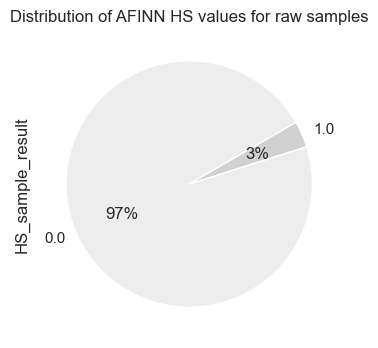

In [22]:
plt.figure(figsize=(4,4))
sns.set(style='white', palette='Greys', font_scale=1.0)

df['HS_sample_result'].value_counts().plot(kind='pie', 
                                          figsize=(4, 4),
                                          autopct='%1.0f%%',
                                          startangle=30, 
                                          title='Distribution of AFINN HS values for raw samples')

In [23]:
# create panda dataframe for results
df_AFINN_HSbinary_results = pd.DataFrame({'sample':df['sample'], 'HSbinary':df['HSbinary'], 'prediction':df['HS_sample_result']})
df_AFINN_HSbinary_results

,sample,HSbinary,prediction
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,0,0.0
1,"Urheiluhotelli, halpa ja hiljainen.",0,0.0
2,Penkillä istuessani katselen kumpuasi ja kauni...,0,0.0
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",0,0.0
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,0,0.0
...,...,...,...
9277,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,0,0.0
9278,Jos uit uimahallissa/ uima-altaassa tms niin T...,0,0.0
9279,"Heini, Sirli, Virpi, Tyyni",0,0.0
9280,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,0,0.0


In [24]:
HSbinary = df_AFINN_HSbinary_results['HSbinary'].tolist()
predictions = df_AFINN_HSbinary_results['prediction'].tolist()

In [31]:
from sklearn.metrics import confusion_matrix, classification_report

class_names = ['not HS', 'HS']

print(classification_report(HSbinary, predictions, target_names=class_names, zero_division=0))

              precision    recall  f1-score   support

      not HS       1.00      0.97      0.98      9282
          HS       0.00      0.00      0.00         0

    accuracy                           0.97      9282
   macro avg       0.50      0.48      0.49      9282
weighted avg       1.00      0.97      0.98      9282



In [32]:
print(confusion_matrix(HSbinary, predictions))

[[8964  318]
 [   0    0]]


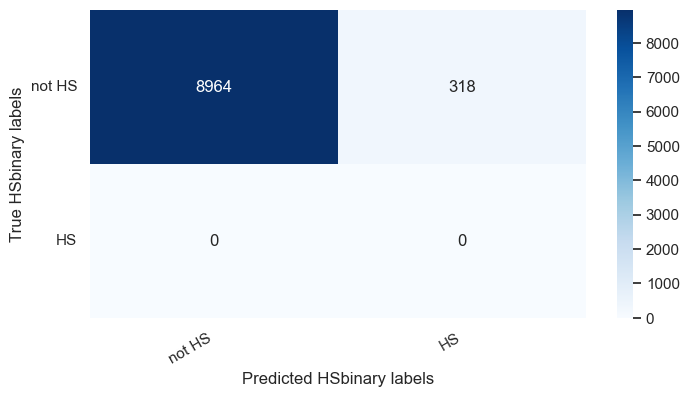

In [33]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True HSbinary labels')
    plt.xlabel('Predicted HSbinary labels');

cm = confusion_matrix(HSbinary, predictions)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [34]:
# metrics for binary classification
# --------------------------------------------
# The positive value is 1 and the negative value is 0.

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# calculate accuracy
# In multilabel classification, this function computes subset accuracy: 
# the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.
total_accuracy = accuracy_score(HSbinary, predictions, normalize=True, sample_weight=None)
print('Accuracy  ', total_accuracy)

# calculate f1
# The formula for the F1 score is:    F1 = 2 * (precision * recall) / (precision + recall)
# 'binary': Only report results for the class specified by pos_label. 
# This is applicable only if targets (y_{true,pred}) are binary.
#total_f1 = f1_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), zero_division=0)
total_f1 = f1_score(HSbinary, predictions, average='binary', sample_weight=None, zero_division=0)
print('F1  ', total_f1)

# calculate precision
# The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. 
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
total_precision = precision_score(HSbinary, predictions, average='binary', sample_weight=None, zero_division=0)
print('Precision  ', total_precision)

# calculate recall
# The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. 
# The recall is intuitively the ability of the classifier to find all the positive samples.
#total_recall = recall_score(HSbinary, predictions, average='binary', labels=np.unique(predictions), sample_weight=None, zero_division=0)
total_recall = recall_score(HSbinary, predictions, average='binary', sample_weight=None, zero_division=0)
print('Recall  ', total_recall)

Accuracy   0.9657401422107305
F1   0.0
Precision   0.0
Recall   0.0


In [35]:
df

,sample,sentiment,polarity,HSbinary,HSstrength,HStarget,HStopic,HSform,stringSample,stringLength,sampleLemmas,sampleTokens,sample_AFword_val,sample_sum,HS_sample_result
0,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,1,3,0,0,NaN,NaN,NaN,Herätysliikkeet ovat yhä elävä osa Suomen ev.l...,58,herätysliike olla yhä elävä osa Suomi ev.lut ....,"[herätysliike, olla, yhä, elävä, osa, suomi, e...","[0, 0]",0.0,0.0
1,"Urheiluhotelli, halpa ja hiljainen.",1,4,0,0,NaN,NaN,NaN,"Urheiluhotelli, halpa ja hiljainen.",35,"urheiluhotelli , halpa ja hiljainen .","[urheiluhotelli, ,, halpa, ja, hiljainen, .]","[0, 0]",0.0,0.0
2,Penkillä istuessani katselen kumpuasi ja kauni...,1,4,0,0,NaN,NaN,NaN,Penkillä istuessani katselen kumpuasi ja kauni...,91,"penkki istua katsella kumpu ja kaunis kukka , ...","[penkki, istua, katsella, kumpu, ja, kaunis, k...","[0, 0, 0, 0, 0]",0.0,0.0
3,"Tarvitsee vain asentaa Java koneelle, muut ohj...",1,5,0,0,NaN,NaN,NaN,"Tarvitsee vain asentaa Java koneelle, muut ohj...",180,"tarvita vain asentaa Java kone , muu ohjelma t...","[tarvita, vain, asentaa, java, kone, ,, muu, o...","[0, 0, 0, 0, 0, 0]",0.0,0.0
4,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,1,5,0,0,NaN,NaN,NaN,Tuo kumpi kannattaa nimimerkin juttu on kyllä ...,69,tuo kumpi kannattaa nimimerkki juttu olla kyll...,"[tuo, kumpi, kannattaa, nimimerkki, juttu, oll...","[0, 0, 0, 0, 0]",0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9277,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,0,0,0,0,NaN,NaN,NaN,Poliisi hiillosti Vanhasta tuntikaupalla | Kot...,110,poliisi hiillostaa vanha tuntikauppa | kotimaa...,"[poliisi, hiillostaa, vanha, tuntikauppa, |, k...",[],0.0,0.0
9278,Jos uit uimahallissa/ uima-altaassa tms niin T...,0,0,0,0,NaN,NaN,NaN,Jos uit uimahallissa/ uima-altaassa tms niin T...,125,jos uida uimahallissa/ uima-allas tms niin TOT...,"[jos, uida, uimahallissa, /, uima-allas, tms, ...","[0, 0, 0, 0]",0.0,0.0
9279,"Heini, Sirli, Virpi, Tyyni",0,0,0,0,NaN,NaN,NaN,"Heini, Sirli, Virpi, Tyyni",26,"Heini , Sirli , Virpi , Tyyni","[heini, ,, sirli, ,, virpi, ,, tyyni]",[0],0.0,0.0
9280,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,0,0,0,0,NaN,NaN,NaN,1 490 020 Kirjoja julkaistu tänä vuonna 323 87...,410,1 490 020 kirja julkaista tämä vuosi 323 870 7...,"[1, 490, 020, kirja, julkaista, tämä, vuosi, 3...","[0, 0, 0, 0, 0, 0]",0.0,0.0


In [36]:
# Load dataframe to excel
cwd = os.getcwd()
folder = '\\afinnfin\\data\\'
excel_file = 'FinnSentiment_positive_neutral_samples_HSlabels'
excel_postfix = '.xlsx'
excel_source = cwd + folder + excel_file + excel_postfix

# get dataframe to excel at defined source file
df.to_excel(excel_source, index=False, encoding="utf-8-sig")